# MNIST Experiments
## Imports

In [1]:
from keras.datasets import mnist
import numpy as np
import torch

from lib.others import build_model
from lib.models import Ganomaly2d
import pandas as pd

from sklearn.pipeline import Pipeline

import lib.transformers as tfs

import seaborn as sns

(train_features, train_labels), (test_features, test_labels) = mnist.load_data()

indices = [index for index, label in enumerate(train_labels) if label == 3]
normal_train = train_features[indices][:400]
normal_test = train_features[indices][:541]

normal_train = normal_train.reshape((-1, 1, 28, 28))
normal_test = normal_test.reshape((-1, 1, 28, 28))

indices = [index for index, label in enumerate(test_labels) if label == 8]
eight_test = test_features[indices][:541]
eight_test = eight_test.reshape((-1, 1, 28, 28))

indices = [index for index, label in enumerate(test_labels) if label == 9]
nine_test = test_features[indices][:541]
nine_test = nine_test.reshape((-1, 1, 28, 28))

indices = [index for index, label in enumerate(test_labels) if label == 1]
one_test = test_features[indices][:541]
one_test = one_test.reshape((-1, 1, 28, 28))

In [2]:
# model settings
n_z = 600
n_channels = 1
n_feature_maps = 64

adversarial_weight = 1
contextual_weight = 1
encoder_weight = 70
lambda_weight = 1/70

# training settings
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
n_gpus = 0
workers = 2
batch_size = 16
max_epochs = 50
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# extra callbacks
callbacks = []

# run number
run = 1000
verbose = 1

In [3]:
gan_mnist =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 28, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    adversarial_weight = adversarial_weight,
    contextual_weight = contextual_weight, 
    encoder_weight = encoder_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'stacked_timeseries' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [4]:
pipeline_mnist = \
Pipeline(steps=[
                ('reshaper', tfs.ArrayReshaper((1, 28, 28))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_mnist)
               ])

In [5]:
pipeline_mnist.fit(normal_train)


  epoch    adversarial_loss    contextual_loss    discriminator_loss    encoder_loss    generator_loss    train_loss     dur
-------  ------------------  -----------------  --------------------  --------------  ----------------  ------------  ------
      1              1.0964            36.4638                0.3457          0.2704           56.4865       56.8322  9.8533
      2              1.4435            36.4744                0.0554          0.0640           42.4004       42.4558  9.8927
      3              1.4953            36.4696                0.0225          0.0347           40.3961       40.4186  9.8792
      4              1.5162            36.4641                0.0124          0.0242           39.6769       39.6892  10.5081
      5              1.5282            36.4579                0.0079          0.0180           39.2475       39.2554  11.2141
      6              1.5379            36.4527                0.0056          0.0155           39.0782       39.0838  11.3

Pipeline(steps=[('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000001E5373F4880>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000001E5373F48E0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly2d(
    (discriminator_loss): BCELoss()
    (contextual_loss): L1Loss()
    (discriminator): DiscriminatorNet2d(
      (features): Sequential(
        (0): Co...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
  ),
))])

In [6]:
normal_results = pipeline_mnist.predict(normal_test)
eight_results = pipeline_mnist.predict(eight_test)
nine_results = pipeline_mnist.predict(nine_test)
one_results = pipeline_mnist.predict(one_test)

In [7]:
results = pd.DataFrame([normal_results, [int(3) for _ in range(541)]]).T
results = results.append(pd.DataFrame([eight_results, [int(8) for _ in range(541)]]).T)
results = results.append(pd.DataFrame([nine_results, [int(9) for _ in range(541)]]).T)
results = results.append(pd.DataFrame([one_results, [int(1) for _ in range(541)]]).T)

results = results.rename({0: 'Anomaly Score', 1: 'Label'}, axis = 1)
results['Label'] = results['Label'].astype(int)

result = results

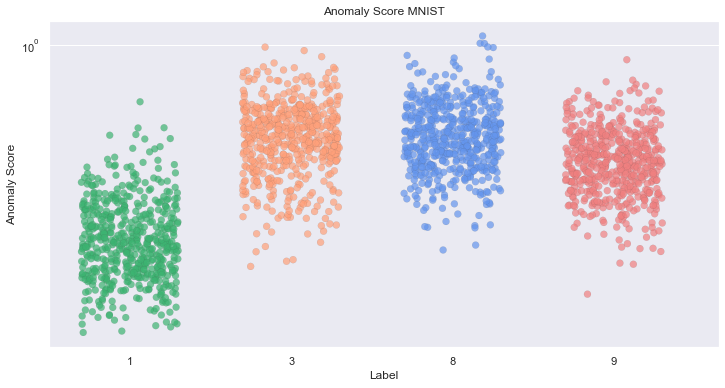

In [10]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 6)}, style = 'darkgrid')
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'Anomaly Score', x = 'Label', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Label')
ax.set_title('Anomaly Score MNIST')

fig.savefig('data/results/anomaly-score_mnist.png', dpi=330, bbox_inches='tight')